#Twitter data analysis
Sentiment analysis of given twitter feed data using neural network

###Import necessary libraries

In [ ]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import tensorflow_hub as hub
assert tf.__version__ >= "2.0"

In [ ]:
import sklearn
assert sklearn.__version__ >= "0.20"
from nltk.classify.scikitlearn import SklearnClassifier
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    
    IS_COLAB = True
except Exception:
    IS_COLAB = False
if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


####Import dataset
dataset used from kaggle https://www.kaggle.com/kazanova/sentiment140

In [ ]:
columns = ['polarity','id','date','query_string','twitter_user','tweet']
df = pd.read_csv('/content/drive/MyDrive/training.csv',
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df.shape

(1600000, 6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,polarity,id,date,query_string,twitter_user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.tail()

,polarity,id,date,query_string,twitter_user,tweet
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#Data Preprocessing
keep only text ,polarity colum remove rest

In [ ]:
df=df[['polarity','tweet']]
df

,polarity,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df['polarity'].value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

There is no tweets with neutral "2"tag , So its binary classification problem now

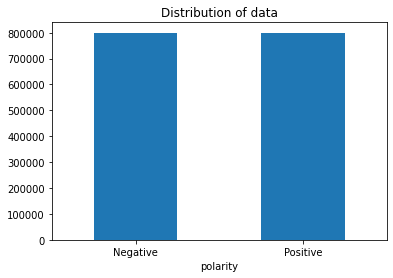

In [ ]:
df['polarity'] = df['polarity'].replace(4,1)
ax = df.groupby('polarity').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['tweet']), list(df['polarity'])

As a quick and easy observation, we can say that dataset has no imbalanced label problem. Negative and Positive labels are equal. The situation of equilibrium will let model to learn more accurate

Check for missing values

In [ ]:
missing_data = df.isna().sum().sort_values(ascending=False)
percentage_missing = round((df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
tweet,0,0.000000
polarity,0,0.000000


Remove stop words,url's from the text field

In [ ]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

In [ ]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [ ]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))
df.head()

,polarity,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


In [ ]:
text_embeddings  = hub.text_embedding_column(
  "tweet", 
  module_spec="https://tfhub.dev/google/universal-sentence-encoder/2"
)

#Split train,test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['polarity'], test_size=0.3, random_state=42)

#Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]



y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_train[0:5]



X_train.shape # Should be (nb_of_records, )



y_test.shape 

(480000, 2)

In [ ]:


MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)


hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )



https://tfhub.dev/google/nnlm-en-dim128/2


#Model build
Model without l2 regularizers

In [ ]:
model = Sequential()
model.add(hub_layer1)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

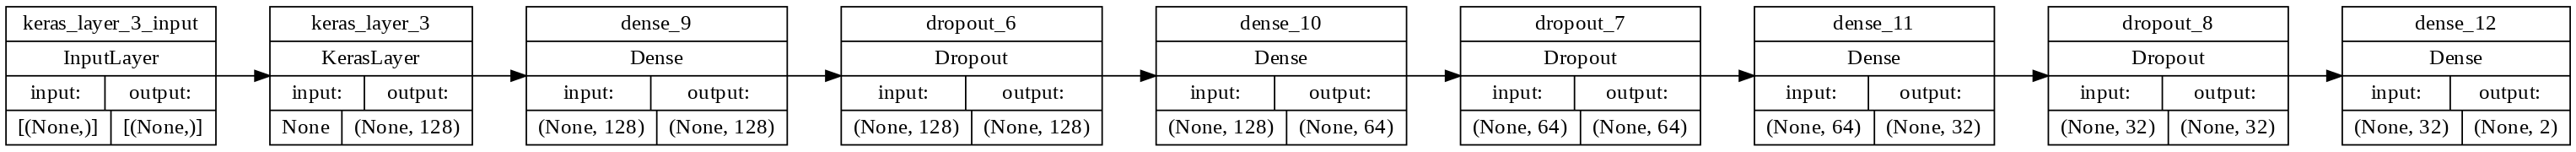

In [ ]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Execute model

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40,
                 batch_size=512,
                 validation_split=0.3,
                 verbose = 1)

Epoch 1/40
1532/1532 [==============================] - 30s 18ms/step - loss: 0.5942 - accuracy: 0.6817 - val_loss: 0.5573 - val_accuracy: 0.7106
Epoch 2/40
1532/1532 [==============================] - 29s 19ms/step - loss: 0.5698 - accuracy: 0.7052 - val_loss: 0.5479 - val_accuracy: 0.7179
Epoch 3/40
1532/1532 [==============================] - 28s 18ms/step - loss: 0.5635 - accuracy: 0.7100 - val_loss: 0.5426 - val_accuracy: 0.7220
Epoch 4/40
1532/1532 [==============================] - 27s 18ms/step - loss: 0.5602 - accuracy: 0.7126 - val_loss: 0.5415 - val_accuracy: 0.7236
Epoch 5/40
1532/1532 [==============================] - 27s 18ms/step - loss: 0.5576 - accuracy: 0.7156 - val_loss: 0.5390 - val_accuracy: 0.7248
Epoch 6/40
1532/1532 [==============================] - 27s 18ms/step - loss: 0.5562 - accuracy: 0.7161 - val_loss: 0.5388 - val_accuracy: 0.7257
Epoch 7/40
1532/1532 [==============================] - 27s 18ms/step - loss: 0.5545 - accuracy: 0.7172 - val_loss: 0.5359 -

#Evaluate model

In [ ]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

15000/15000 - 117s - loss: 0.5304 - accuracy: 0.7311 - 117s/epoch - 8ms/step
[0.5304377675056458, 0.7310666441917419]


##Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [ ]:
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [ ]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [ ]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

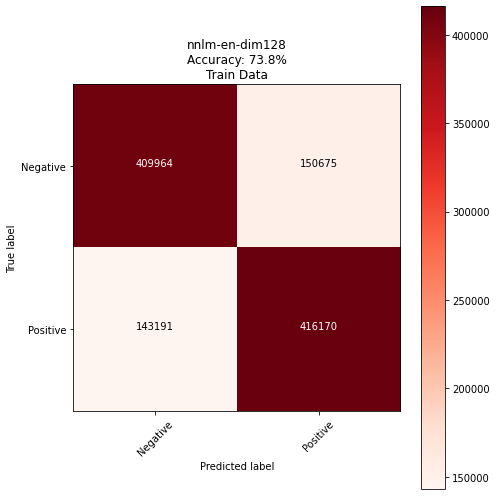

In [ ]:
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data",
                      cmap=plt.cm.Reds);

#MODEL including l2 regularization,dropout

In [ ]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [ ]:
hub_layer2 = hub.KerasLayer(URL, 
                           output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(128,kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64,kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32,kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2,kernel_regularizer=regularizers.l2(0.01), activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)               

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

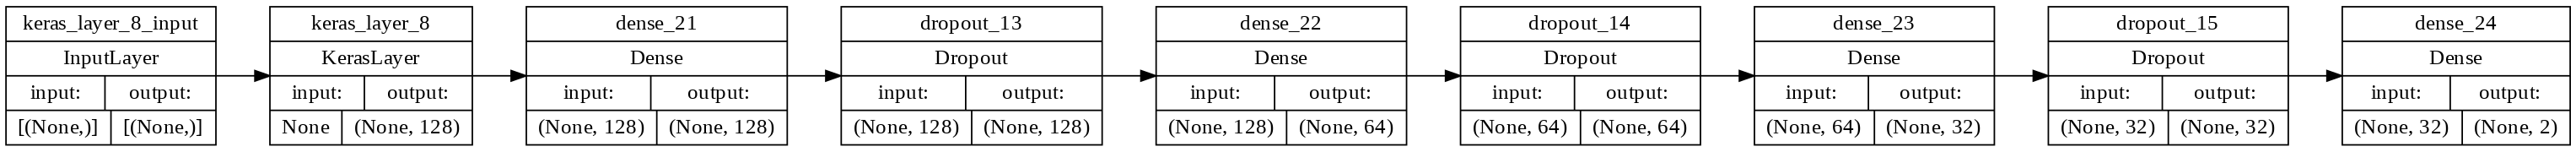

In [ ]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                       show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40, 
                 batch_size=512, 
                 validation_split=0.3,
                 verbose = 1)

Epoch 1/40
1532/1532 [==============================] - 30s 19ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 2/40
1532/1532 [==============================] - 25s 16ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 3/40
1532/1532 [==============================] - 27s 17ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 4/40
1532/1532 [==============================] - 30s 20ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 5/40
1532/1532 [==============================] - 29s 19ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 6/40
1532/1532 [==============================] - 28s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 7/40
1532/1532 [==============================] - 24s 16ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 -

In [ ]:
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [ ]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [ ]:
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: 50% " +  "%" +"\n"+"Train Data",
                      cmap=plt.cm.Blues);

#MODEL 3
 Changing the position of drop out layer

In [ ]:
model = Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(128,kernel_regularizer=regularizers.l2(0.01), activation='relu'))

model.add(keras.layers.Dense(64,kernel_regularizer=regularizers.l2(0.01), activation='relu'))

model.add(keras.layers.Dense(32,kernel_regularizer=regularizers.l2(0.01), activation='relu'))

model.add(keras.layers.Dense(2,kernel_regularizer=regularizers.l2(0.01), activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 2)                 66        
                                                                 
Total params: 124,669,602
Trainable params: 26,914
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40, 
                 batch_size=512, 
                 validation_split=0.3,
                 verbose = 1)

Epoch 1/40
1532/1532 [==============================] - 25s 16ms/step - loss: 0.7721 - accuracy: 0.6728 - val_loss: 0.6794 - val_accuracy: 0.6787
Epoch 2/40
1532/1532 [==============================] - 24s 16ms/step - loss: 0.6795 - accuracy: 0.6786 - val_loss: 0.6779 - val_accuracy: 0.6809
Epoch 3/40
1532/1532 [==============================] - 25s 16ms/step - loss: 0.6791 - accuracy: 0.6789 - val_loss: 0.6784 - val_accuracy: 0.6804
Epoch 4/40
1532/1532 [==============================] - 24s 16ms/step - loss: 0.6790 - accuracy: 0.6789 - val_loss: 0.6780 - val_accuracy: 0.6803
Epoch 5/40
1532/1532 [==============================] - 24s 16ms/step - loss: 0.6788 - accuracy: 0.6794 - val_loss: 0.6778 - val_accuracy: 0.6810
Epoch 6/40
1532/1532 [==============================] - 24s 16ms/step - loss: 0.6786 - accuracy: 0.6794 - val_loss: 0.6778 - val_accuracy: 0.6806
Epoch 7/40
1532/1532 [==============================] - 25s 16ms/step - loss: 0.6785 - accuracy: 0.6797 - val_loss: 0.6778 -

From the three models we can see that model with without l2 regularization provides better validation accuracy